In [1]:
import numpy as np
import pandas as pd
import yaml
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns

# Import

First we open a file containing a dictionary of columns and associated data types generated in `../../optimize/`, then we read input file.

In [2]:
with open('../input/dtypes.yaml', 'r') as yamlfile:
    column_types = yaml.load(yamlfile)

read_csv_opts = {'sep': '|',
                 'quotechar': '"',
                 'compression': 'gzip',
                 'encoding': 'utf-8',
                 'dtype': column_types,
                 'parse_dates': ['MissionDate'],
                 'infer_datetime_format': True}

df = pd.read_csv('../input/ice-air.csv.gz', **read_csv_opts)

df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1731580 entries, 0 to 1731579
Data columns (total 44 columns):
Status                  category
Sex                     category
Convictions             category
GangMember              category
ClassLvl                float32
Age                     float32
MissionDate             datetime64[ns]
MissionNumber           uint32
PULOC                   category
DropLoc                 category
StrikeFromList          float32
ReasonStruck            category
R-T                     category
Code                    category
CountryOfCitizenship    category
Juvenile                bool
MissionWeek             uint8
MissionQuarter          uint8
MissionYear             uint16
MissionMonth            uint8
Criminality             category
FamilyUnitFlag          float32
UnaccompaniedFlag       float32
AlienMasterID           uint32
MissionID               uint16
air_AirportID           float32
air_AirportName         category
air_City         

In [3]:
passenger_cols = ['AlienMasterID', 'Status', 'Sex', 'Convictions', 'GangMember',
       'ClassLvl', 'Age', 'MissionNumber', 'PULOC', 'DropLoc',
       'StrikeFromList', 'ReasonStruck', 'R-T', 'Code', 'CountryOfCitizenship',
       'Juvenile', 'MissionWeek', 'MissionQuarter', 'MissionYear',
       'MissionMonth', 'Criminality', 'FamilyUnitFlag', 'UnaccompaniedFlag',
       'MissionID', 'MissionDate']
airport_cols = ['air_AirportID', 'air_AirportName', 'air_City',
       'st_StateID', 'st_StateAbbr', 'AOR_AORID', 'AOR_AOR', 'AOR_AORName',
       'air_Country', 'air2_AirportID', 'air2_AirportName', 'air2_City',
       'st2_StateID', 'st2_StateAbbr', 'aor2_AORID', 'aor2_AOR',
       'aor2_AORName', 'air2_Country']

# Global variables

Here we calculate top-level data on the global scope of the ICE Air dataset.

In [4]:
pre_drop = len(df)
df = df.drop_duplicates()
post_drop = len(df)
assert pre_drop == post_drop

number_of_records = len(df)
print(f'Number of records: {number_of_records}')

unique_AlienMasterID = len(set(df['AlienMasterID']))
assert sum(df['AlienMasterID'].isnull()) == 0
print(f"Unique AlienMasterID values: {unique_AlienMasterID}")

Number of records: 1731580
Unique AlienMasterID values: 1731580


In [5]:
# Span of AlienMaster ID values is greater than number of unique values, so some must be skipped.
df['AlienMasterID'].max() - df['AlienMasterID'].min()

2042246

No missing values in ID fields. IDs repeat.

In [6]:
unique_MissionID = len(set(df['MissionID']))
assert sum(df['MissionID'].isnull()) == 0
print(f"Unique MissionID values: {unique_MissionID}")

unique_MissionNumber = len(set(df['MissionNumber']))
assert sum(df['MissionNumber'].isnull()) == 0
print(f"Unique MissionNumber values: {unique_MissionNumber}")

Unique MissionID values: 14961
Unique MissionNumber values: 14961


One to one relationship of MissionID to MissionNumber. These fields seem to be equivalent. Ordering does not affect calculations.

In [7]:
assert sum(df.groupby(['MissionID', 'MissionNumber'])['MissionNumber'].nunique() > 1) == 0
assert sum(df.groupby(['MissionNumber', 'MissionID'])['MissionID'].nunique() > 1) == 0

missions = df.groupby(['MissionDate', 'MissionID', 'MissionNumber', 'PULOC', 'DropLoc'])
missions_alt = df.groupby(['MissionDate', 'MissionNumber', 'MissionID',  'PULOC', 'DropLoc'])
assert len(missions) == len(missions_alt)
del missions_alt
mission_segments = len(missions)
print(f"{mission_segments} unique flight segments, grouped by mission and date.")

41172 unique flight segments, grouped by mission and date.


In [8]:
mission_segments / len(set(df['MissionID']))

2.7519550832163624

The following is a glimpse of flight segments from the first day in the dataset, showing how flight segments are grouped by `MissionID`/`MissionNumber`. We cannot assume that a unique combination of `PULOC` and `DropLoc` on a given mission represents a specific flight path, only the pickup and dropoff locations of each passenger. Missions can include a combination of both removal (`R`) and transfer (`T`) flights.

If we take ICE's Data Dictionary on its face, each `MissionID`/`MissionNumber` represents a single flight, possibly with multiple pickup and dropoff stops on its itinerary. Reconstructing the exact flight itinerary from this data may not be possible, given that there are no timestamp values below the day level, nor any other explicit indications of consecutive flight segments, other than the original ordering of the records.

In [9]:
missions_rt = df.groupby(['MissionDate', 'MissionID', 'MissionNumber', 'R-T', 'PULOC', 'DropLoc'])
missions_rt['AlienMasterID'].nunique().head(15)

MissionDate  MissionID  MissionNumber  R-T  PULOC  DropLoc
2010-10-01   105        110005         T    KMDT   KAEX       122
             106        110006         R    KHRL   MGGT        67
                                            KSAT   MGGT        37
             107        110007         R    KAEX   MHLM        97
             108        110008         R    KMCI   KHRL        35
                                            KORD   KHRL        63
                                       T    KMCI   KAEX        10
                                            KORD   KAEX        25
             131        110002         R    KBFL   KSAN        13
                                            KOAK   KSAN        43
                                       T    KBFL   KIWA         3
                                                   KSAN         8
                                            KOAK   KIWA        13
                                                   KSAN         5
                 

In [10]:
earliest_record = df['MissionDate'].min()
print(f'Earliest record: {earliest_record.date()}')
latest_record = df['MissionDate'].max()
print(f'Earliest record: {latest_record.date()}')

Earliest record: 2010-10-01
Earliest record: 2018-12-05


In [11]:
number_of_pickup_airports = len(set(df['PULOC'].dropna()))
number_of_dropoff_airports = len(set(df['DropLoc'].dropna()))
total_airports = len(set(df['PULOC']).union(set(df['DropLoc'])))
print(f'Number of pickup airports: {number_of_pickup_airports}')
print(f'Number of dropoff airports: {number_of_dropoff_airports}')
print(f'Total airports: {total_airports}')

Number of pickup airports: 81
Number of dropoff airports: 206
Total airports: 223


In [12]:
number_of_pickup_countries = len(set(df['air_Country'].dropna()))
number_of_dropoff_countries = len(set(df['air2_Country'].dropna()))
total_countries = len(set(df['air_Country']).union(set(df['air2_Country'])))
print(f'Number of pickup countries: {number_of_pickup_countries}')
print(f'Number of dropoff countries: {number_of_dropoff_countries}')
print(f'Total countries: {total_countries}')

Number of pickup countries: 10
Number of dropoff countries: 119
Total countries: 119


The number of unique pickup and dropoff airports represented in the dataset per year can be interpreted as a metric for the expansion of the ICE Air network over time.

In [13]:
droplocs_per_fy = df.resample('AS-OCT', on='MissionDate')['DropLoc']
pulocs_per_fy = df.resample('AS-OCT', on='MissionDate')['PULOC']
drop_countries_per_fy = df.resample('AS-OCT', on='MissionDate')['air2_Country']
pu_countries_per_fy = df.resample('AS-OCT', on='MissionDate')['air_Country']

In [14]:
assert sum(df['DropLoc'].isnull()) == 0
assert sum(df['PULOC'].isnull()) == 0

In [15]:
unique_droplocs = droplocs_per_fy.nunique()
unique_pulocs = pulocs_per_fy.nunique()
unique_countries = drop_countries_per_fy.nunique()
expansion = pd.DataFrame({'Unique Pickup Airports': unique_pulocs,
                          'Unique Dropoff Airports': unique_droplocs,
                          'Unique Destination Countries': unique_countries})
expansion.index = expansion.index.year + 1
expansion.index.name = 'FY'
# expansion.to_csv('../output/iceair-expansion.csv')
expansion

,Unique Pickup Airports,Unique Dropoff Airports,Unique Destination Countries
FY,,,
2011,41,69,35
2012,44,78,42
2013,45,48,16
2014,41,62,20
2015,36,60,32
2016,39,86,53
2017,40,85,49
2018,40,107,69
2019,31,52,23


In [16]:
expansion.loc[2018, 'Unique Pickup Airports']

40

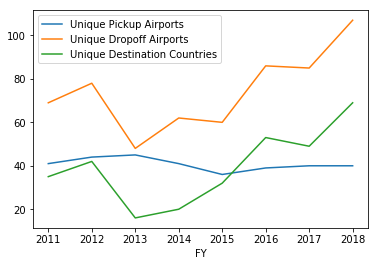

In [17]:
expansion.loc[2011:2018].plot()

In [18]:
usa_pu = set(df.loc[df['air_Country'] == 'USA']['PULOC'])
usa_drop = set(df.loc[df['air2_Country'] == 'USA']['DropLoc'])
foreign_pu = set(df.loc[df['air_Country'] != 'USA']['PULOC'])
foreign_drop = set(df.loc[df['air2_Country'] != 'USA']['DropLoc'])

In [19]:
len(usa_pu.union(usa_drop))

88

In [20]:
foreign_pu

{'EDDF', 'MDSD', 'MGGT', 'MHLM', 'MKJP', 'MMMD', 'MSLP', 'MTPP', 'SEGU'}

In [22]:
len(foreign_pu.union(foreign_drop))

135

# Most common pickup, dropoff airports

By unique `AlienMasterID` values:

In [23]:
df.drop_duplicates('AlienMasterID')['air_AirportName'].value_counts().head(10)

Alexandria International Airport                        239893
Brownsville South Padre Island International Airport    204895
Phoenix-Mesa-Gateway Airport                            196139
El Paso International Airport                           136127
Valley International Airport                            124994
San Antonio International Airport                       107434
Columbus Metropolitan Airport                            80797
Harrisburg International Airport                         76348
Laredo International Airport                             56409
Miami International Airport                              55588
Name: air_AirportName, dtype: int64

In [24]:
df.drop_duplicates('AlienMasterID')['air2_AirportName'].value_counts().head(10)

La Aurora Airport                                       326755
Ramon Villeda Morales International Airport             202328
Alexandria International Airport                        169316
El Salvador International Airport                       157480
Valley International Airport                            148679
Phoenix-Mesa-Gateway Airport                             93892
El Paso International Airport                            87186
Licenciado Benito Juarez International Airport           85584
Brownsville South Padre Island International Airport     66444
San Diego International Airport                          62942
Name: air2_AirportName, dtype: int64

By unique `MissionID` values, an estimate of total number of flights (dropping duplicate date and mission values doesn't change calculation):

In [25]:
count1 = df.drop_duplicates('MissionID')['air_AirportName'].value_counts()
count2 = df.drop_duplicates(['MissionDate', 'MissionID'])['air_AirportName'].value_counts()
assert sum(count1 == count2) == len(count1)
del count1, count2
df.drop_duplicates('MissionID')['air_AirportName'].value_counts().head(10)

Phoenix-Mesa-Gateway Airport                            3185
Alexandria International Airport                        3044
Brownsville South Padre Island International Airport    1550
San Antonio International Airport                       1475
Miami International Airport                             1052
Valley International Airport                             900
El Paso International Airport                            750
Columbus Metropolitan Airport                            369
Laredo International Airport                             279
Harrisburg International Airport                         259
Name: air_AirportName, dtype: int64

In [26]:
count1 = df.drop_duplicates('MissionID')['air2_AirportName'].value_counts()
count2 = df.drop_duplicates(['MissionDate', 'MissionID'])['air2_AirportName'].value_counts()
assert sum(count1 == count2) == len(count1)
del count1, count2
df.drop_duplicates('MissionID')['air2_AirportName'].value_counts().head(10)

La Aurora Airport                                 2924
Ramon Villeda Morales International Airport       1735
El Salvador International Airport                 1420
Alexandria International Airport                   943
Valley International Airport                       927
Licenciado Benito Juarez International Airport     642
San Diego International Airport                    623
El Paso International Airport                      523
Newark Liberty International Airport               403
Harrisburg International Airport                   391
Name: air2_AirportName, dtype: int64

In [27]:
pickup_countries = set(df['air_Country'].dropna())
print(f'Number of pickup countries: {len(pickup_countries)}')
dropoff_countries = set(df['air2_Country'].dropna())
print(f'Number of dropoff countries: {len(dropoff_countries)}')
all_countries = pickup_countries.union(dropoff_countries)
print(f'Total countries in ICE Air network (including US): {len(dropoff_countries)}')

Number of pickup countries: 10
Number of dropoff countries: 119
Total countries in ICE Air network (including US): 119


Top nationalities:

In [28]:
df.drop_duplicates(subset='AlienMasterID')['CountryOfCitizenship'].value_counts().head(10)

MEXICO                567622
GUATEMALA             421109
HONDURAS              303920
EL SALVADOR           256406
DOMINICAN REPUBLIC     31703
ECUADOR                25686
HAITI                  23308
NICARAGUA              18677
COLOMBIA               14520
JAMAICA                12798
Name: CountryOfCitizenship, dtype: int64

In [29]:
removals = df['R-T'] == 'R'
transfers = df['R-T'] == 'T'

removal_df = df[removals]
transfer_df = df[transfers]

Top nationalities for removals:

In [30]:
removal_df.drop_duplicates(subset='AlienMasterID')['CountryOfCitizenship'].value_counts().head(10)

MEXICO                466107
GUATEMALA             326523
HONDURAS              223159
EL SALVADOR           157245
DOMINICAN REPUBLIC     14878
ECUADOR                 9968
HAITI                   8685
NICARAGUA               8215
COLOMBIA                7372
JAMAICA                 6169
Name: CountryOfCitizenship, dtype: int64

Top nationalities for transfers:

In [31]:
transfer_df.drop_duplicates(subset='AlienMasterID')['CountryOfCitizenship'].value_counts().head(10)

MEXICO                101514
EL SALVADOR            99161
GUATEMALA              94586
HONDURAS               80748
DOMINICAN REPUBLIC     16825
ECUADOR                15717
HAITI                  14623
NICARAGUA              10462
INDIA                   8557
COLOMBIA                7148
Name: CountryOfCitizenship, dtype: int64

In [148]:
removal_df.groupby('CountryOfCitizenship')['MissionID'].nunique()['MAURITANIA']

4

In [149]:
removal_df.groupby('CountryOfCitizenship')['AlienMasterID'].nunique()['MAURITANIA']

12

In [151]:
transfer_df.groupby('CountryOfCitizenship')['AlienMasterID'].nunique()['MAURITANIA']

116

In [164]:
df['R-T'].value_counts(dropna=False)

R             1232870
T              498692
NaN                15
Ineligible          2
No-show             1
Name: R-T, dtype: int64

In [168]:
rem

MissionDate
2011-10-01    264230
Freq: AS-OCT, Name: AlienMasterID, dtype: int64

# Status

In [32]:
status_count = removal_df.drop_duplicates(subset='AlienMasterID')['Status'].str.upper().value_counts(dropna=False)

In [33]:
status = pd.read_csv('../../share/resources/status.csv')

In [34]:
valid_status_codes = list(status['Code'])

In [35]:
status_dict = dict(zip(status['Code'], status['Status']))

In [36]:
problematic = ['2A', '2B', '5C', '5D', '5E', '5F', '8A', '8B', '8D', '8G', '8H', '11']
pending = ['2A', '2B', '8A', '8B', '8D']
benefit = ['5C', '5D']
expedited_admin = ['8F', '8G', '8H', '8I', '11']

In [37]:
problematic_count = 0
valid = removal_df['Status'].str.upper().isin(valid_status_codes)
valid_count = sum(valid)
invalid = ~removal_df['Status'].str.upper().isin(valid_status_codes)
invalid_count = sum(invalid)

print(f'ICE Air - All removals')
print()
print(f'ICE status codes for passengers on direct removal flights.')
print(f'(Statuses which may raise due process concerns starred)')
print()
print(f'{valid_count} valid values.')
print(f'{invalid_count} invalid values.')
print()
for c in valid_status_codes:
    
    try:
        count = status_count[c]
    except KeyError:
        count = 0
    
    if c in problematic:
        problematic_count = problematic_count + count
        print(f'[{c}]: *{count}* ({status_dict[c]})')
    else:
        print(f'[{c}]: {count} ({status_dict[c]})')
print()
print(f'{problematic_count} problematic cases.')

ICE Air - All removals

ICE status codes for passengers on direct removal flights.
(Statuses which may raise due process concerns starred)

838303 valid values.
394567 invalid values.

[1A]: 55093 (Voluntary Departure – Un-Expired and Un-Extended Voluntary Departure.)
[1B]: 282 (Voluntary Departure - Extended Departure Period)
[1C]: 8 (Exipred Voluntary Departure Period - Referred to Investigation)
[2A]: *2223* (Deportable – Under Adjudication by IJ)
[2B]: *96* (Deportable – Under Adjudication by BIA)
[3]: 20557 (Deportable – Administratively Final Order)
[5A]: 14 (Referred for Investigation - No Show for Hearing - No Final O...)
[5B]: 797 (Removable – ICE Fugitive)
[5C]: *16* (Relief Granted – Withholding of Deportation/Removal)
[5D]: *86* (Final Order of Deportation/Removal – Deferred Action Granted.)
[5E]: *32* (Relief Granted – Extended Voluntary Departure)
[5F]: *57* (Unable to Obtain Travel Document)
[8A]: *1489* (Excludable/Inadmissible – Hearing Not Commenced)
[8B]: *4072* (Exc

In [38]:
invalid_status = df[~df['Status'].isin(valid_status_codes)]
status_counts = invalid_status['Status'].value_counts()
bad_statuses = list(status_counts[status_counts > 0].index)

In [39]:
status_counts.head(25)

REMOVAL           231309
RM                164378
NO STATUS          50830
NTA                20931
TRANSFER - F/O     19507
TRANSFER - NTA      9795
REINSTATE           6819
ER-TRANSFER         5917
STAGER              4771
NTA - TRANSFER      3036
F/O - TRANSFER      2620
TRANSFER            2174
REINST              1800
TRANSFER-NTA        1468
WD                  1030
FINAL ORDER          909
JUVI                 845
1/15/1900            747
NTA-TRANSFER         680
WA/NTA               666
NTA-TRFD             663
V/R                  635
DEPORT               584
REIN                 569
RE-INSTATE           484
Name: Status, dtype: int64

## Status by FY for removals & transfers

In [40]:
status_fy = removal_df.drop_duplicates(subset='AlienMasterID').resample('AS-OCT', on='MissionDate')['Status'].value_counts().unstack()

In [41]:
total = removal_df.drop_duplicates(subset='AlienMasterID').resample('AS-OCT', on='MissionDate')['AlienMasterID'].nunique()

In [42]:
status_fy[expedited_admin]

Status,8F,8G,8H,8I,11
MissionDate,,,,,
2010-10-01,9899.0,1.0,NaN,NaN,174.0
2011-10-01,22038.0,NaN,NaN,NaN,92.0
2012-10-01,52132.0,462.0,9.0,5.0,2298.0
2013-10-01,53894.0,2556.0,164.0,33.0,3008.0
2014-10-01,32056.0,4049.0,61.0,80.0,3832.0
2015-10-01,29940.0,10335.0,246.0,128.0,3741.0
2016-10-01,26146.0,13062.0,1264.0,214.0,2913.0
2017-10-01,32818.0,12421.0,346.0,273.0,2640.0
2018-10-01,6290.0,2686.0,38.0,45.0,399.0


In [43]:
status_fy[valid_status_codes].to_csv('../output/valid_status_by_year.csv')

In [44]:
all_others = status_fy[status_fy.columns[~status_fy.columns.isin(valid_status_codes)]].sum(axis=1)
all_others.name = 'all_others'

In [45]:
status_table = pd.concat([status_fy[valid_status_codes], all_others], axis=1).T

In [46]:
status_table.to_csv('../output/removal_status_by_year.csv')
(status_table/total).to_csv('../output/removal_status_by_year_percent.csv')

# Removal versus transfer rates

We might be interested in whether some groups are disproportionately transferred prior to removal. However, these values will be highly skewed because some groups have very few total removals, and high rate of transfer does not necessarily imply rights violations.

In [47]:
removal_count = df.loc[df['R-T'] == 'R'].drop_duplicates(subset='AlienMasterID')['CountryOfCitizenship'].value_counts()
transfer_count =  df.loc[df['R-T'] == 'T'].drop_duplicates(subset='AlienMasterID')['CountryOfCitizenship'].value_counts()
transfer_rate = (transfer_count / removal_count).sort_values(ascending = False)
valid_comparisons = transfer_rate[transfer_rate != np.inf]

In [48]:
country = "GUATEMALA"

In [49]:
print(f'{country}: {round(valid_comparisons[country], 3)} transfers per removal ({transfer_count[country]}/{removal_count[country]})')

GUATEMALA: 0.29 transfers per removal (94586/326523)


# Most common, most passenger flight paths

We can rank flight paths by number of missions or unique passengers, perhaps for calculating costs of a common flight path.

In [50]:
most_common_flight_paths = df.groupby(['PULOC','DropLoc'])['MissionID'].nunique()
most_common_flight_path = most_common_flight_paths.idxmax()
most_common_flight_path_count =  most_common_flight_paths[most_common_flight_path]
most_passenger_flight_paths = df.groupby(['PULOC','DropLoc'])['AlienMasterID'].nunique()
most_passenger_flight_path = most_passenger_flight_paths.idxmax()
most_passenger_flight_path_count = most_passenger_flight_paths[most_passenger_flight_path]

In [51]:
print(f'Most frequent flight path: {most_common_flight_path}, {most_common_flight_path_count} missions')
print(f'Flight path with most passengers: {most_passenger_flight_path}, {most_passenger_flight_path_count} passengers')

Most frequent flight path: ('KOAK', 'KSAN'), 919 missions
Flight path with most passengers: ('KBRO', 'MGGT'), 91714 passengers


In [52]:
most_passenger_flight_path_trips = df.groupby(['PULOC','DropLoc'])['MissionNumber'].nunique()[most_passenger_flight_path]

In [53]:
cost_per_hour = 7785

In [54]:
kbro_to_mggt_duration_hrs = 5

In [55]:
most_passenger_flight_path_trips * kbro_to_mggt_duration_hrs * cost_per_hour

35694225

In [56]:
flight_path_rank = most_common_flight_paths.sort_values(ascending=False).reset_index()

In [57]:
flight_path_cross_table = most_common_flight_paths.unstack()
passenger_count_cross_table = most_passenger_flight_paths.unstack()

This is probably not a super interesting way to display this info but...

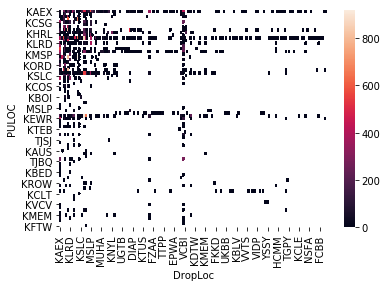

In [58]:
sns.heatmap(flight_path_cross_table)

# Trend charts

Charts for global trends in the ICE Air dataset, starting with simple plot of total removals and transfers per fiscal year (excluding FY19):

In [59]:
removal_df = df.loc[df['R-T'] == 'R']
transfer_df = df.loc[df['R-T'] == 'T']
removal_df.set_index('MissionDate', inplace=True)
transfer_df.set_index('MissionDate', inplace=True)

In [60]:
removal_percent = len(df.loc[df['R-T'] == 'R']) / len(df)
transfer_percent = len(df.loc[df['R-T'] == 'T']) / len(df)

In [61]:
round((len(set(df['MissionID'])) / 1000), 1)

15.0

In [62]:
df.name = 'Passengers'
removal_df.name = 'Removals'
transfer_df.name = 'Transfers'

In [63]:
df.set_index('MissionDate', inplace=True)

In [64]:
total_passengers = df['AlienMasterID'].resample('AS-OCT').nunique().rename('Total passengers', inplace=True)
annual_removals = removal_df['AlienMasterID'].resample('AS-OCT').nunique().rename('Total removals', inplace=True)
annual_transfers = transfer_df['AlienMasterID'].resample('AS-OCT').nunique().rename('Total transfers', inplace=True)
annual_removal_flights = removal_df['MissionID'].resample('AS-OCT').nunique()
annual_transfer_flights = transfer_df['MissionID'].resample('AS-OCT').nunique()

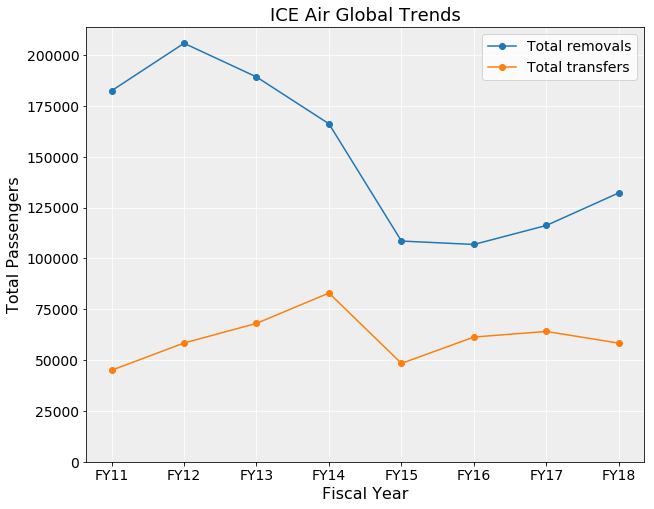

In [121]:
def pickup_dropoff_trend(data):
    
    fig, ax = plt.subplots()
    
    for datum in data:
        ax = datum.plot(style='o-', legend=True)
    
    ax.set_axisbelow(True)
    ax.set_ylabel('Total Passengers', fontsize=16)
    ax.set_ylim(0)
    ax.set_xticklabels([f'FY{str(x)[2:4]}' for x in range(2010,2019)])
    ax.set_xlabel('Fiscal Year', fontsize=16)
    ax.set_title(f'ICE Air Global Trends', fontsize=18)
    ax.tick_params(labelsize=14)
    ax.legend(fontsize=14)
    ax.set_facecolor('#EEEEEE')
    ax.grid(color='#FFFFFF')
    
    fig.set_size_inches(10, 8)
    fig.savefig(f'../output/ICE-Air-Global-Trends.png', dpi=100)
    return fig, ax

plot = pickup_dropoff_trend([annual_removals['2010':'2017'], annual_transfers['2010':'2017']]);

In [82]:
r_t_annual = pd.DataFrame({'Removals': annual_removals['2010':'2017'], 'Transfers': annual_transfers['2010':'2017']})
r_t_annual.index = [f'FY{str(x)[2:4]}' for x in r_t_annual.index.year + 1]

In [172]:
r_t_annual.loc['FY12'].sum()

264230

In [128]:
def removal_transfer_bar(data, title=str, filename=str, xlabel=str, ylabel=str):
    
    fig, ax = plt.subplots()
    
    data.plot(kind='bar', stacked=True, legend=True, ax=ax).legend(bbox_to_anchor=(1,1))
    
    ax.set_axisbelow(True)
    ax.set_ylabel(ylabel, fontsize=16)
    ax.set_xlabel(xlabel, fontsize=16)
    
    ax.set_title(title, fontsize=18)
    ax.tick_params(labelsize=14)
    plt.xticks(rotation=0)
    ax.set_facecolor('#EEEEEE')
    ax.grid(color='#FFFFFF')
    
    fig.set_size_inches(10, 8)
    fig.savefig(f'../output/{filename}.png', dpi=100)
    return fig, ax

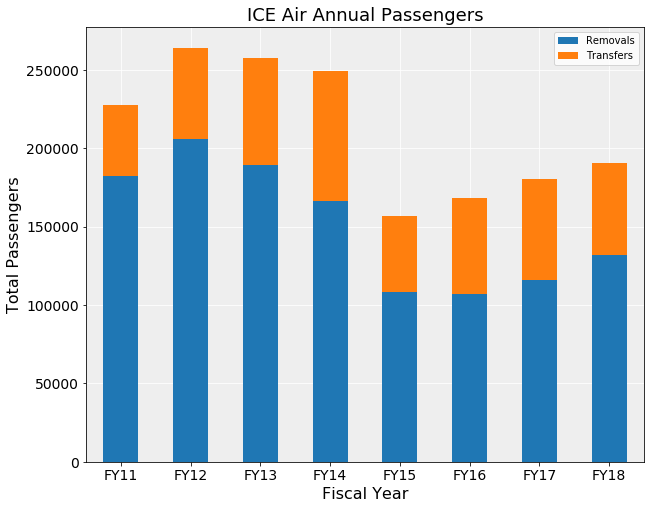

In [129]:
removal_transfer_bar(r_t_annual,
                     title=f'ICE Air Annual Passengers',
                     filename=f'annual_passengers_bar',
                     ylabel=f'Total Passengers',
                     xlabel='Fiscal Year');

In [179]:
r_t_annual['Removals'].idxmin()

'FY16'

In [180]:
r_t_annual

,Removals,Transfers
FY11,182447,45011
FY12,205814,58416
FY13,189259,68065
FY14,166204,82989
FY15,108554,48392
FY16,106880,61352
FY17,116231,64097
FY18,132249,58352


# Charts of nationalities per year

## Top 5 per year

To look at removals or other variables by `CountryOfCitizenship` per fiscal year (excluding FY19), we will want to select most common values and sum the rest, in order to create a clean chart. Method below selects top 5 nationalities per year, and sums the rest as "ALL OTHERS".

This is slightly counterintuitive, for example it creates illusion of no Dominican Republic removals in FY17. Maybe better solution would be to display for each year any nationality that is in top 5 for any given year. Alternatively, we could just plot top 5 values, or include several more over a certain threshold. Or we could plot all values for nationalities which are in the top 5 for any year.

In [130]:
# df.set_index('MissionDate', inplace=True)

In [131]:
# Set DataFrame or subset to chart here. Remember to set name as well.
df_to_analyze = removal_df
df_to_analyze.name = removal_df.name

In [132]:
g = df_to_analyze.groupby([pd.Grouper(freq='AS-OCT', sort=True), 'CountryOfCitizenship'])['AlienMasterID', 'MissionID'].nunique()
country_of_citizenship_by_year = g.reset_index()
country_of_citizenship_by_year.rename({'MissionDate': 'FY'}, axis='columns', inplace=True)
country_of_citizenship_by_year.set_index('FY', inplace=True)
country_of_citizenship_by_year.sort_values(by='AlienMasterID', ascending=False, inplace=True)

# country_of_citizenship_by_year.to_csv(f'../output/{airport}_country_of_citizenship_by_year.csv', index=True)

In [133]:
# Selecting only years for which we have full data (FY2011 - FY2018).
country_of_citizenship_by_year = country_of_citizenship_by_year['2010':'2017']

In [134]:
removal_nationality_by_year = country_of_citizenship_by_year.groupby([pd.Grouper(freq='AS-OCT'),'CountryOfCitizenship'])[['AlienMasterID']].sum().dropna(how='all',axis=0).unstack()
# removal_nationality_by_year.to_csv(f'../output/removal_nationality_by_year.csv')

In [135]:
removal_nationality_by_year

AlienMasterID                                            \
CountryOfCitizenship        BRAZIL CAMEROON CAPE VERDE CHINA COLOMBIA   CUBA   
FY                                                                             
2010-10-01                     1.0      2.0        4.0   6.0   1059.0   31.0   
2011-10-01                     NaN      1.0        NaN   NaN   1020.0   34.0   
2012-10-01                     NaN      NaN        NaN   NaN    943.0   16.0   
2013-10-01                     NaN      7.0        NaN   NaN    865.0    6.0   
2014-10-01                     NaN      9.0        NaN  16.0    847.0   16.0   
2015-10-01                     NaN      3.0        NaN   NaN    847.0   25.0   
2016-10-01                     NaN      5.0        NaN  47.0    795.0   53.0   
2017-10-01                     8.0     13.0        7.0  93.0    866.0  255.0   

                                                                     ...    \
CountryOfCitizenship DOMINICAN REPUBLIC ECUADOR EL SALVADOR  GHANA   ...     
FY                                                                   ...     
2010-10-01                       2343.0  1436.0     15817.0   17.0   ...     
2011-10-01                       2281.0  1593.0     18107.0   14.0   ...     
2012-10-01                       1849.0  1318.0     20178.0    NaN   ...     
2013-10-01                       1747.0  1377.0     26507.0    NaN   ...     
2014-10-01                       1552.0  1153.0     21378.0    NaN   ...     
2015-10-01                       1556.0   980.0     20089.0   17.0   ...     
2016-10-01                       1696.0   929.0     17970.0  172.0   ...     
2017-10-01                       1520.0  1036.0     14223.0  130.0   ...     

                                                                      \
CountryOfCitizenship SOUTH AFRICA ST. LUCIA BURKINA FASO SOUTH SUDAN   
FY                                                                     
2010-10-01                    NaN       NaN          NaN         NaN   
2011-10-01                    NaN       NaN          NaN         NaN   
2012-10-01                    NaN       NaN          NaN         NaN   
2013-10-01                    NaN       NaN          NaN         NaN   
2014-10-01                    NaN       NaN          NaN         NaN   
2015-10-01                    NaN       NaN          NaN         NaN   
2016-10-01                    NaN       NaN          NaN         NaN   
2017-10-01                    1.0       2.0          5.0        61.0   

                                                                         \
CountryOfCitizenship ANTIGUA & BARBUDA BURMA SAMOA UNITED ARAB EMIRATES   
FY                                                                        
2010-10-01                         NaN   NaN   NaN                  NaN   
2011-10-01                         NaN   NaN   NaN                  NaN   
2012-10-01                         NaN   NaN   NaN                  NaN   
2013-10-01                         NaN   NaN   NaN                  NaN   
2014-10-01                         NaN   NaN   NaN                  NaN   
2015-10-01                         NaN   NaN   NaN                  NaN   
2016-10-01                         NaN   NaN   NaN                  NaN   
2017-10-01                         3.0  33.0   6.0                  1.0   

                                          
CountryOfCitizenship PALESTINIAN NAMIBIA  
FY                                        
2010-10-01                   NaN     NaN  
2011-10-01                   NaN     NaN  
2012-10-01                   NaN     NaN  
2013-10-01                   NaN     NaN  
2014-10-01                   NaN     NaN  
2015-10-01                   NaN     NaN  
2016-10-01                   NaN     NaN  
2017-10-01                   4.0     2.0  

[8 rows x 130 columns]

In [136]:
top_5_df = pd.DataFrame()

for year in country_of_citizenship_by_year.index.unique():
    temp = country_of_citizenship_by_year.loc[f'{year}'][['CountryOfCitizenship', 'AlienMasterID']]
    temp_top_5 = temp[0:5]
    if len(temp) > 5:
        all_other_count = sum(temp['AlienMasterID'][5:])
    else:
        all_other_count = 0
    other_df = pd.DataFrame([['ALL OTHERS', all_other_count]],
                            columns=['CountryOfCitizenship',
                                     'AlienMasterID'],
                            index=[year])
    temp_top_5 = temp_top_5.append(other_df)
    top_5_df = top_5_df.append(temp_top_5)

top_5_df.sort_index(inplace=True)
top_5_df.index = [f'FY{str(x)[2:4]}' for x in top_5_df.index.year + 1]

top_5_data = pd.pivot_table(data=top_5_df,
                       index=top_5_df.index,
                       columns='CountryOfCitizenship',
                       values='AlienMasterID',
                       aggfunc=np.sum,
                       fill_value=0)

In [137]:
# Note 0 values in this version of chart. Missing values are included in "ALL OTHERS" category.
top_5_data

CountryOfCitizenship,ALL OTHERS,DOMINICAN REPUBLIC,EL SALVADOR,GUATEMALA,HAITI,HONDURAS,MEXICO
FY11,4965,2343,15817,30472,0,21069,107781
FY12,5449,2281,18107,38399,0,30815,110763
FY13,4868,1849,20178,47955,0,35759,78650
FY14,4712,1747,26507,54135,0,39825,39278
FY15,3951,1552,21378,32599,0,19613,29461
FY16,3879,1556,20089,32963,0,21311,27082
FY17,6306,0,17970,32198,5549,21241,32967
FY18,5973,1520,14223,48645,0,27150,34738


In [138]:
top_5_data = top_5_data.reindex(top_5_data.sum().sort_values(ascending=False).index, axis=1)
cols = list(top_5_data.columns)
cols.remove('ALL OTHERS')
cols.append('ALL OTHERS')
top_5_data = top_5_data[cols]
top_5_data.columns = top_5_data.columns.str.title()
top_5_data.columns.name = 'Country of Citizenship'

In [161]:
def country_of_citizenship_trend(data, title=str, filename=str, xlabel=str, ylabel=str):
    
    fig, ax = plt.subplots()
    
    data.plot(kind='bar', stacked=True, legend=True, ax=ax).legend(bbox_to_anchor=(1,1))

    
    ax.set_axisbelow(True)
    ax.set_facecolor('#EEEEEE')
    ax.grid(color='#FFFFFF')
    ax.set_ylabel(ylabel, fontsize=16)
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_title(title, fontsize=18)
    ax.tick_params(labelsize=14)
    plt.xticks(rotation=0)

    fig.set_size_inches(10, 8)
    fig.savefig(f'../output/{filename}.png', dpi=100)
    return fig, ax

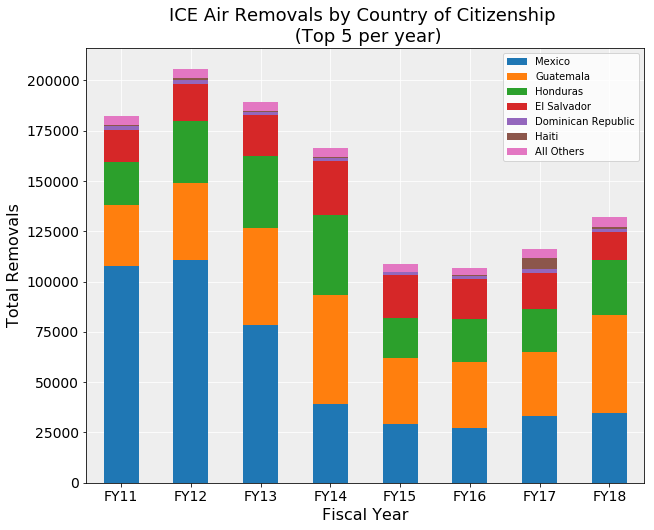

In [162]:
country_of_citizenship_trend(top_5_data,
                             title=f'ICE Air {df_to_analyze.name} by Country of Citizenship \n (Top 5 per year)',
                             filename=f'top5_total_deportation_nationalities_per_year',
                             ylabel=f'Total {df_to_analyze.name}',
                             xlabel='Fiscal Year');

## Top 5 any year

Here's the alternate plot showing all nationalities which break the top 5 in any year. A bit messier, but outliers are still clear (El Salvador in FY14, Haiti in FY17, India in FY18), steady trends possibly clearer (Ecuador, Dominican Republic).

In [143]:
in_top_5 = list()
for year in country_of_citizenship_by_year.index.unique():
    temp = country_of_citizenship_by_year.loc[f'{year}'][['CountryOfCitizenship', 'AlienMasterID']]
    temp_top_5 = temp[0:5]
    in_top_5.extend(list(temp_top_5['CountryOfCitizenship']))

In [144]:
top_5_df = pd.DataFrame()

for year in country_of_citizenship_by_year.index.unique():
    temp = country_of_citizenship_by_year.loc[f'{year}'][['CountryOfCitizenship', 'AlienMasterID']]
    temp_top_5 = temp[temp['CountryOfCitizenship'].isin(list(set(in_top_5)))]
    if len(temp) > 5:
        all_others = temp[~temp['CountryOfCitizenship'].isin(list(set(in_top_5)))]
        all_other_count = sum(all_others['AlienMasterID'])
    else:
        all_other_count = 0
    other_df = pd.DataFrame([['ALL OTHERS', all_other_count]],
                            columns=['CountryOfCitizenship',
                                     'AlienMasterID'],
                            index=[year])
    temp_top_5 = temp_top_5.append(other_df)
    top_5_df = top_5_df.append(temp_top_5)

top_5_df.sort_index(inplace=True)
top_5_df.index = [f'FY{str(x)[2:4]}' for x in top_5_df.index.year + 1]

top_5_data = pd.pivot_table(data=top_5_df,
                       index=top_5_df.index,
                       columns='CountryOfCitizenship',
                       values='AlienMasterID',
                       aggfunc=np.sum,
                       fill_value=0)

top_5_data = top_5_data.reindex(top_5_data.sum().sort_values(ascending=False).index, axis=1)
cols = list(top_5_data.columns)
cols.remove('ALL OTHERS')
cols.append('ALL OTHERS')
top_5_data = top_5_data[cols]
top_5_data.columns = top_5_data.columns.str.title()
top_5_data.columns.name = 'Country of Citizenship'

In [145]:
# Table for this version of chart is much better
top_5_data

Country of Citizenship,Mexico,Guatemala,Honduras,El Salvador,Dominican Republic,Haiti,All Others
FY11,107781,30472,21069,15817,2343,228,4737
FY12,110763,38399,30815,18107,2281,547,4902
FY13,78650,47955,35759,20178,1849,452,4416
FY14,39278,54135,39825,26507,1747,338,4374
FY15,29461,32599,19613,21378,1552,369,3582
FY16,27082,32963,21311,20089,1556,267,3612
FY17,32967,32198,21241,17970,1696,5549,4610
FY18,34738,48645,27150,14223,1520,805,5168


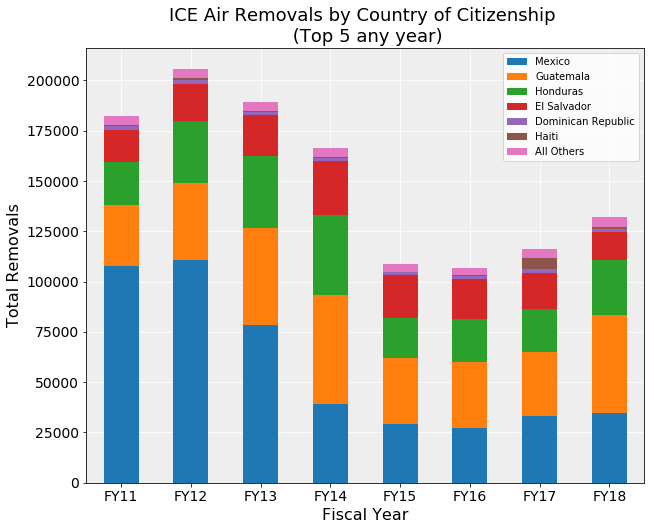

In [146]:
country_of_citizenship_trend(top_5_data,
                             title=f'ICE Air {df_to_analyze.name.title()} by Country of Citizenship \n (Top 5 any year)',
                             filename=f'top5_total_{df_to_analyze.name.lower()}_nationalities_any_year',
                             ylabel=f'Total {df_to_analyze.name.title()}',
                             xlabel='Fiscal Year');

In [212]:
cent_am = ['MEXICO', 'GUATEMALA', 'HONDURAS', 'EL SALVADOR']

cent_am_df = pd.DataFrame()

for year in country_of_citizenship_by_year.index.unique():
    temp = country_of_citizenship_by_year.loc[f'{year}'][['CountryOfCitizenship', 'AlienMasterID']]
    temp_cent_am = temp[temp['CountryOfCitizenship'].isin(list(set(cent_am)))]
    cent_am_count = sum(temp_cent_am['AlienMasterID'])
    if len(temp) > 5:
        all_others = temp[~temp['CountryOfCitizenship'].isin(list(set(cent_am)))]
        all_other_count = sum(all_others['AlienMasterID'])
    else:
        all_other_count = 0
    temp_df = pd.DataFrame([['MEXICO + NORTHERN TRIANGLE', cent_am_count],
                            ['ALL OTHERS', all_other_count]],
                            columns=['CountryOfCitizenship',
                                     'AlienMasterID'],
                            index=[year, year])
    cent_am_df = cent_am_df.append(temp_df)
    
cent_am_df.sort_index(inplace=True)
cent_am_df.index = [f'FY{str(x)[2:4]}' for x in cent_am_df.index.year + 1]

cent_am_data = pd.pivot_table(data=cent_am_df,
                       index=cent_am_df.index,
                       columns='CountryOfCitizenship',
                       values='AlienMasterID',
                       aggfunc=np.sum,
                       fill_value=0)

cent_am_data = cent_am_data.reindex(cent_am_data.sum().sort_values(ascending=False).index, axis=1)
cols = list(cent_am_data.columns)
cols.remove('ALL OTHERS')
cols.append('ALL OTHERS')
cent_am_data = cent_am_data[cols]
cent_am_data.columns = cent_am_data.columns.str.title()
cent_am_data.columns.name = 'Country of Citizenship'

In [239]:
(cent_am_data.div(cent_am_data.sum(axis=1), axis=0) * 100).mean()

Country of Citizenship
Mexico + Northern Triangle    94.847936
All Others                     5.152064
dtype: float64

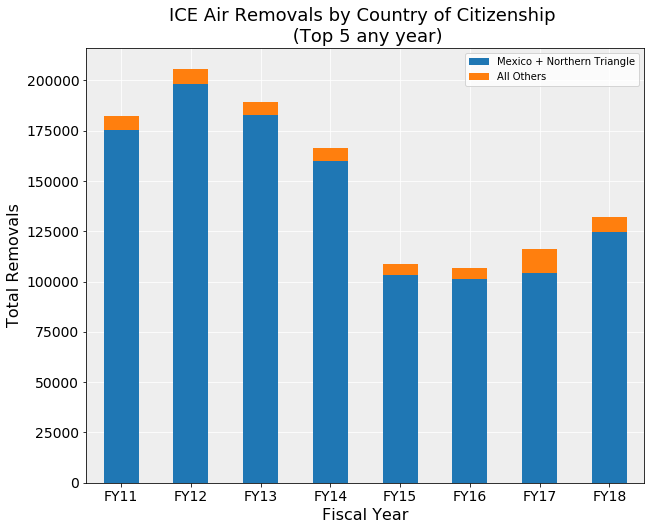

In [216]:
country_of_citizenship_trend(cent_am_data,
                             title=f'ICE Air {df_to_analyze.name.title()} by Country of Citizenship \n (Top 5 any year)',
                             filename=f'top5_total_{df_to_analyze.name.lower()}_nationalities_any_year',
                             ylabel=f'Total {df_to_analyze.name.title()}',
                             xlabel='Fiscal Year');

In [244]:
sum(removal_df['CountryOfCitizenship'].isin(cent_am)) / len(removal_df) * 100

95.14660913153861

# Investigating other global variables

In [ ]:
df['Juvenile'].value_counts(dropna=False)

In [ ]:
df['Age'].hist(bins=10)

In [ ]:
df.groupby(['CountryOfCitizenship', 'R-T'])['Age'].mean()

In [ ]:
df.groupby([pd.Grouper(freq='AS-OCT')])['Age'].mean()

In [ ]:
df.groupby([pd.Grouper(freq='AS-OCT')])['Sex'].value_counts() / df.groupby([pd.Grouper(freq='AS-OCT')]).size() * 100

# Different geographic subsets

## US state

In [ ]:
df.columns

In [ ]:
state = 'WA'

In [ ]:
state_pickup_df = df[df['st_StateAbbr'] == state]

In [ ]:
state_dropoff_df = df[df['st2_StateAbbr'] == state]

In [ ]:
state_pickup_df['PULOC'].value_counts().head(5)

In [ ]:
state_all = pd.concat([state_pickup_df, state_dropoff_df])

## Country

In [ ]:
country = 'USA'

In [ ]:
country_pickup_df = df[df['air_Country'] == country]
country_dropoff_df = df[df['air2_Country'] == country]
country_all = pd.concat([country_pickup_df, country_dropoff_df])

In [ ]:
country_pickup_df.groupby(['PULOC', 'R-T'])['AlienMasterID'].nunique()

In [ ]:
country_dropoff_df.groupby(['DropLoc', 'R-T'])['AlienMasterID'].nunique()

In [ ]:
country_removals = country_all[country_all['R-T'] == 'R']
country_transfers = country_all[country_all['R-T'] == 'T']

In [ ]:
country_removals.drop_duplicates(subset='AlienMasterID')['PULOC'].value_counts().head(10)

In [ ]:
country_transfers.drop_duplicates(subset='AlienMasterID')['PULOC'].value_counts().head(10)

# ICE total removal statistics

In [220]:
ice_ero_totals = [396906,
                  409849,
                  368644,
                  315943,
                  235413,
                  240255,
                  226119,
                  256086]

In [234]:
ice_total_comparison = pd.DataFrame({'ICE Air Removals': list(annual_removals['2010':'2017']), 'ICE ERO Total Removals': ice_ero_totals},
            index=annual_removals['2010':'2017'].index)

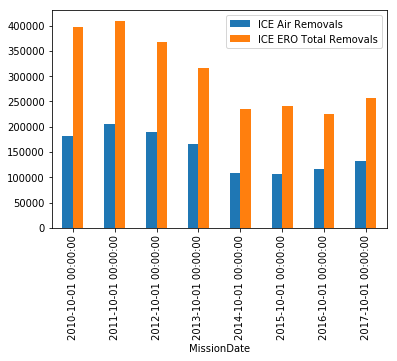

In [235]:
ice_total_comparison.plot(kind='bar')

In [249]:
ice_total_comparison['Percent'] = ice_total_comparison['ICE Air Removals'] / ice_total_comparison['ICE ERO Total Removals']

In [255]:
ice_total_comparison['Percent'] * 100

MissionDate
2010-10-01    45.967307
2011-10-01    50.217031
2012-10-01    51.339232
2013-10-01    52.605692
2014-10-01    46.112152
2015-10-01    44.486067
2016-10-01    51.402580
2017-10-01    51.642417
Freq: AS-OCT, Name: Percent, dtype: float64